
4422102/4422102 [==============================] - 0s 0us/step


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 28, 28, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 28, 28, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                   

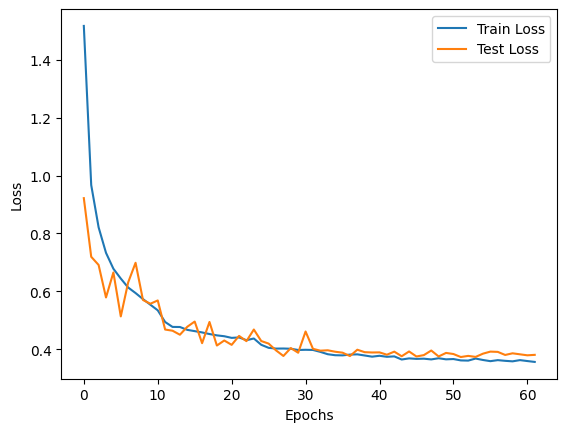

최적 에포크: 52
Epoch 1/52
938/938 [==============================] - 26s 26ms/step - loss: 1.4775 - accuracy: 0.4960
Epoch 2/52
938/938 [==============================] - 25s 27ms/step - loss: 0.9394 - accuracy: 0.6606
Epoch 3/52
938/938 [==============================] - 26s 27ms/step - loss: 0.7923 - accuracy: 0.7163
Epoch 4/52
938/938 [==============================] - 26s 28ms/step - loss: 0.7181 - accuracy: 0.7437
Epoch 5/52
938/938 [==============================] - 25s 27ms/step - loss: 0.6609 - accuracy: 0.7641
Epoch 6/52
938/938 [==============================] - 25s 27ms/step - loss: 0.6225 - accuracy: 0.7794
Epoch 7/52
938/938 [==============================] - 26s 27ms/step - loss: 0.5923 - accuracy: 0.7869
Epoch 8/52
938/938 [==============================] - 24s 26ms/step - loss: 0.5673 - accuracy: 0.7974
Epoch 9/52
938/938 [==============================] - 24s 25ms/step - loss: 0.5541 - accuracy: 0.8014
Epoch 10/52
938/938 [==============================] - 24s 25ms/step - 

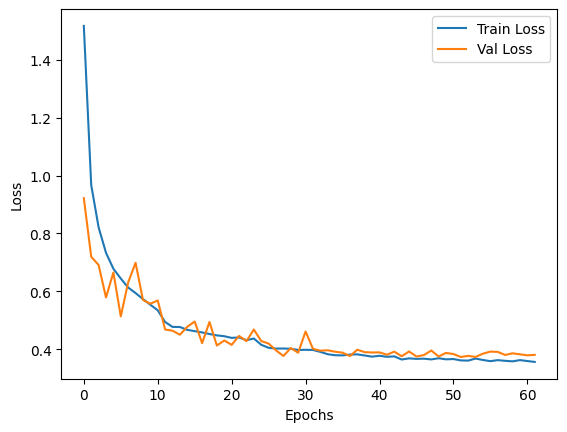

In [1]:
# CNN 모델 구축과 훈련

## 준비

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np

## 데이터셋 불러오기 및 전처리

(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

# 채널 차원 추가 (Conv2D 입력: (28,28,1))
x_train = x_train[..., tf.newaxis].astype("float32") / 255.0
x_test = x_test[..., tf.newaxis].astype("float32") / 255.0

# 훈련/검증 데이터 분리 (90% train, 10% val)
val_split = 0.1
split_idx = int((1-val_split) * len(x_train))

x_train_sub, y_train_sub = x_train[:split_idx], y_train[:split_idx]
x_val, y_val = x_train[split_idx:], y_train[split_idx:]

# 데이터 증강
data_augmentation = keras.Sequential([
    layers.RandomRotation(0.2),        # 회전
    layers.RandomZoom(0.2),            # 확대/축소
    layers.RandomTranslation(0.2, 0.2),# 이동
    layers.RandomFlip("horizontal"),   # 좌우반전
])

batch_size = 64

train_ds = (
    tf.data.Dataset.from_tensor_slices((x_train_sub, y_train_sub))
    .shuffle(10000)
    .batch(batch_size)
    .map(lambda x, y: (data_augmentation(x), y))
    .prefetch(tf.data.AUTOTUNE)
)

val_ds = (
    tf.data.Dataset.from_tensor_slices((x_val, y_val))
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

test_ds = (
    tf.data.Dataset.from_tensor_slices((x_test, y_test))
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

## 모델 정의

# 모델 만들기
def create_model():
    model = keras.Sequential([
        layers.Input((28,28,1)),
        # 첫 번째 블록
        layers.Conv2D(32, (3,3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3,3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),

        # 두 번째 블록
        layers.Conv2D(64, (3,3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3,3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),

        # 세 번째 블록
        layers.Conv2D(128, (3,3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3,3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.4),

        # 분류 레이어
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])
    return model

model = create_model()

# 모델 요약
model.summary()

## 모델 컴파일 및 학습

# 모델 컴파일
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
# 콜백 설정
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    './model_cnn.keras',
    save_best_only = True,
    monitor='val_loss')
early_stopping_cb = keras.callbacks.EarlyStopping(
    patience = 10,
    restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-5
)
# 모델 훈련
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks = [checkpoint_cb, early_stopping_cb, reduce_lr]
)

## 손실 곡선 시각화

plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Test Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

## 최종모델 학습

# 최적 에포크 + 전체 데이터로 최종 모델 재학습
best_epoch = np.argmin(history.history['val_loss']) + 1  # +1은 0-based index
print("최적 에포크:", best_epoch)

# 전체 훈련 데이터 + 증강 적용
train_full_ds = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(60000)
    .batch(batch_size)
    .map(lambda x, y: (data_augmentation(x), y))
    .prefetch(tf.data.AUTOTUNE)
)

# 새로운 모델 생성
final_model = create_model()
final_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 체크포인트 콜백 (최종 모델 저장)
final_checkpoint_cb = keras.callbacks.ModelCheckpoint(
    './model_cnn_final.keras',
    save_best_only=True,
    monitor='loss'
)

final_model.fit(
    train_full_ds,
    epochs=best_epoch,
    callbacks=[final_checkpoint_cb]
)

## 최종모델 평가

# 최종 모델 테스트 평가
test_loss, test_acc = final_model.evaluate(test_ds)
print(f"최종 테스트 정확도: {test_acc*100:.2f}%")

## 최종모델 손실 곡선 시각화

# 학습 곡선 시각화
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()